# Messages throughput

In this notebook, we do an analysis of the average amount of messages we get to send compressed per second for a worst case scenario of a payload with a high entropy composed of random numbers.

These tests have been run on the commit 79551eaa from branch compression.

For this we ran as a publisher:
```
 ./target/release/examples/z_pub_thr 8 -m peer -c test.json5 --high-entropy --no-multicast-scouting -e tcp/127.0.0.1:7447
```
and as a receiver
```
./target/release/examples/z_sub_thr -m peer --no-multicast-scouting -l tcp/127.0.0.1:7447 -n 10000 -s 1000
```

varying the size of the messages size from 8 bytes to 56KB. For 64KB message size an error occurs that is yet to be determined what happened (something related to the orchestrator).

A python script was used to generate all the output results, which can be found on this repo under script.py:

In [24]:
cat ../script.py

import subprocess

KB = 1024

SIZES = [8, 16, 32, 64, 128, 256, 512, KB, 2*KB, 4*KB, 8*KB, 16*KB, 24*KB, 32*KB, 40*KB, 48*KB, 56*KB, 64*KB]

def run_compression():
    rcv_cmds = ["./target/release/examples/z_sub_thr", "-m", "peer", "--no-multicast-scouting", "-l", "tcp/127.0.0.1:7447", "-n", "10000", "-s", "1000"]
    for size in SIZES:
        send_cmds = ["./target/release/examples/z_pub_thr", str(size), "-m", "peer", "-c", "test.json5", "--no-multicast-scouting", "--high-entropy", "-e", "tcp/127.0.0.1:7447"]
        log_file = "compression_logs/compression_" + str(size) + ".txt"
        batch_size_file = "batch_sizes/batch_size_" + str(size) + ".txt"
        f1 = open(log_file, "w")
        f2 = open(batch_size_file, "w")
        receiver = subprocess.Popen(rcv_cmds, stdout=f1)
        sender = subprocess.Popen(send_cmds, stdout=f2)
        receiver.wait()
        sender.terminate()

run_compression()


Where in test.json5 we enable the compression.

In [25]:
import pandas as pd
import matplotlib.pyplot as plt


In [26]:
KB = 1024
SIZES = [8, 16, 32, 64, 128, 256, 512, KB, 2*KB, 4*KB, 8*KB, 16*KB, 24*KB, 32*KB, 40*KB, 48*KB, 56*KB]

In [27]:
def parse_file(filename):
    file = open(filename, 'r')
    lines = file.readlines()
    measurements = []
    for line in lines:
        measurement = line.strip(' msg/s\n')
        measurements = measurements + [float(measurement)]
    return measurements
        

In [28]:
a = [1,2,3]
a = a + [4]
a

[1, 2, 3, 4]

In [29]:
import numpy as np

def calculate_avg_msgs(measurements):
    return np.average(measurements)

In [30]:
averages_low_entropy = {}
averages_high_entropy = {}
for size in SIZES:
    averages_low_entropy[size] = calculate_avg_msgs(parse_file('../low_entropy/compression_logs/compression_' + str(size) + '.txt'))
    averages_high_entropy[size] = calculate_avg_msgs(parse_file('../high_entropy2/compression_logs/compression_' + str(size) + '.txt'))

print(averages_low_entropy)
print(averages_high_entropy)

{8: 5228442.539722652, 16: 5544021.9357960075, 32: 5561968.033888417, 64: 5463115.040434198, 128: 5291871.082228159, 256: 4972713.586898372, 512: 4230945.263329854, 1024: 3410526.8011144083, 2048: 2521838.818963517, 4096: 1644024.9608445007, 8192: 717332.949988796, 16384: 258781.61561063924, 24576: 144316.7301232572, 32768: 66273.81570667727, 40960: 59638.682597424064, 49152: 51448.51106977467, 57344: 44653.467288018575}
{8: 5259589.025440426, 16: 5647642.823842117, 32: 5411261.16083261, 64: 5489974.706304184, 128: 5258755.227125162, 256: 4975111.597700903, 512: 4315851.261476877, 1024: 3481602.851945176, 2048: 2551689.2444185247, 4096: 1627052.170540244, 8192: 774784.8356429185, 16384: 301426.98370689974, 24576: 192511.85834188483, 32768: 95216.69773043442, 40960: 89061.13586262074, 49152: 82275.91632493949, 57344: 77083.43411090836}


In [31]:
df_low_entropy = pd.DataFrame(averages_low_entropy.items())
df_high_entropy = pd.DataFrame(averages_high_entropy.items())

In [32]:
df_low_entropy

,0,1
0,8,5.228443e+06
1,16,5.544022e+06
2,32,5.561968e+06
3,64,5.463115e+06
4,128,5.291871e+06
5,256,4.972714e+06
6,512,4.230945e+06
7,1024,3.410527e+06
8,2048,2.521839e+06
9,4096,1.644025e+06


In [33]:
df_high_entropy

,0,1
0,8,5.259589e+06
1,16,5.647643e+06
2,32,5.411261e+06
3,64,5.489975e+06
4,128,5.258755e+06
5,256,4.975112e+06
6,512,4.315851e+06
7,1024,3.481603e+06
8,2048,2.551689e+06
9,4096,1.627052e+06


In [34]:
def plot_messages_per_second():
    fig, ax = plt.subplots()

    ax.plot(df_low_entropy[0], df_low_entropy[1], label="Low entropy", marker='o')
    ax.plot(df_high_entropy[0], df_high_entropy[1], label="High entropy", marker='o')

    ax.set_xticks(df_low_entropy[0])
    ax.set_ylabel('Msgs/s')
    ax.set_xlabel('Message size')
    ax.set_xscale('log')
    ax.set_title('Average messages per second depending on the size of the message with compression with a low entropy payload')
    ax.grid(True)
    ax.legend(loc='center right', ncols=1)
    fig.set_figwidth(15)
    # ax.tick_params(labelcolor='r', labelsize='medium', width=3)
    plt.show()


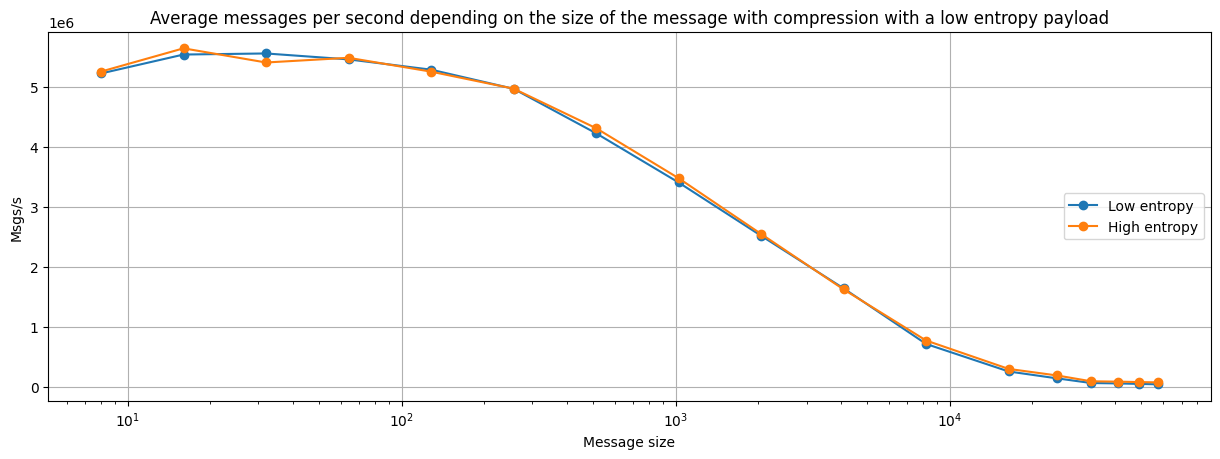

In [35]:
plot_messages_per_second()